In [1]:
import pickle

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from pt_runner.cnn import CheckpointHandler, DataHandlerPT, EarlyStopper, calc_metrices


In [2]:
# New run
NEW_RUN = True
DT_REF = None

# Resuming
# NEW_RUN = False
# DT_REF = "2025-05-28_12-35"

In [3]:
RANDOM_STATE = 0

In [4]:
with open("mnist_small.pickle", "rb") as file:
    data = pickle.load(file)

In [5]:
_X = data["_X"].astype(np.float64)
_Y = data["_Y"].astype(np.int32)
print(_X.shape)
print(_X.dtype)
print(_Y.shape)
print(_Y.dtype)

(4000, 1, 28, 28)
float64
(4000, 1)
int32


In [6]:
data_handler = DataHandlerPT(_X=_X, _Y=_Y)

In [7]:
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: input channels=3 (e.g., RGB), output channels=16, kernel size=3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        # Fully connected layer
        self.fc1 = nn.Linear(
            32 * 4 * 4, num_classes
        )  # Adjust input size depending on image size!

    def forward(self, X):
        # 1st Conv + Activation + Pooling
        X = self.conv1(X)
        X = self.relu(X)
        X = self.max_pool(X)
        # 2nd Conv + Activation + Pooling
        X = self.conv2(X)
        X = self.relu(X)
        X = self.max_pool(X)

        X = self.adaptive_pool(X)
        # Flatten the output for the fully connected layer
        X = X.view(X.shape[0], -1)
        # Fully connected output
        X = self.fc1(X)
        return X


model = SimpleCNN(num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)
loss_fn = nn.CrossEntropyLoss()


# Test
X = torch.randn(10, 1, 28, 28)
model(X)

tensor([[-0.1485,  0.1142, -0.5658, -0.1067,  0.2824,  0.3770,  0.2047,  0.4108,
         -0.2490, -0.2488],
        [-0.1727,  0.1505, -0.5595, -0.0779,  0.2719,  0.3775,  0.1661,  0.5621,
         -0.2780, -0.2098],
        [-0.1002,  0.1438, -0.5889, -0.0984,  0.2639,  0.4820,  0.1665,  0.5161,
         -0.2495, -0.2260],
        [-0.1156,  0.0606, -0.5914, -0.0704,  0.2248,  0.4015,  0.2285,  0.4840,
         -0.2396, -0.2442],
        [-0.1482,  0.1206, -0.5667, -0.0650,  0.2583,  0.4879,  0.1712,  0.4686,
         -0.2314, -0.2494],
        [-0.1343,  0.1649, -0.5864, -0.0794,  0.2556,  0.4284,  0.2382,  0.4668,
         -0.2701, -0.2754],
        [-0.1130,  0.1938, -0.4919, -0.0344,  0.2235,  0.4051,  0.1602,  0.4896,
         -0.2566, -0.2322],
        [-0.0998,  0.1163, -0.5613, -0.0854,  0.2607,  0.3794,  0.2756,  0.4740,
         -0.2502, -0.2193],
        [-0.1265,  0.1096, -0.6066, -0.0923,  0.2787,  0.4124,  0.1888,  0.4778,
         -0.2457, -0.2316],
        [-0.0971,  

In [8]:
from torchinfo import summary

input_size = (100, 1, 32, 32)  # (batch_size, channels, height, width)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [100, 10]                 --
├─Conv2d: 1-1                            [100, 16, 32, 32]         160
├─ReLU: 1-2                              [100, 16, 32, 32]         --
├─MaxPool2d: 1-3                         [100, 16, 16, 16]         --
├─Conv2d: 1-4                            [100, 32, 16, 16]         4,640
├─ReLU: 1-5                              [100, 32, 16, 16]         --
├─MaxPool2d: 1-6                         [100, 32, 8, 8]           --
├─AdaptiveAvgPool2d: 1-7                 [100, 32, 4, 4]           --
├─Linear: 1-8                            [100, 10]                 5,130
Total params: 9,930
Trainable params: 9,930
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 135.68
Input size (MB): 0.41
Forward/backward pass size (MB): 19.67
Params size (MB): 0.04
Estimated Total Size (MB): 20.12

`tensorboard --logdir=src/T03_cnn/runs`

In [ ]:
n_epochs = 100  # number of epochs to run
batch_size = 10  # size of each batch
validation_interval = 4  # Evaluate every 10 epochs
log_name = "C1"

# Save/load
cph = CheckpointHandler()
cph.make_dir("./checkpoints")
if NEW_RUN:
    dt = cph.get_dt()
    log_dir = f"runs/{dt}"
    save_path = f"./checkpoints/{dt}.pth"
    epoch_start = 0
else:
    log_dir = f"runs/{DT_REF}"
    load_path = f"./checkpoints/{DT_REF}.pth"
    save_path = load_path
    model, optimizer, epoch, val_loss = cph.load(
        load_path=load_path, model=model, optimizer=optimizer
    )
    epoch_start = epoch
    print(f"Resuming from epoch: {epoch_start}")

epoch_end = epoch_start + n_epochs

# Initialize Components
early_stopper = EarlyStopper(patience=5)
writer = SummaryWriter(log_dir=log_dir, purge_step=epoch_start)

# Data
data_handler.split_and_scale(test_size=0.2, val_size=0.1, random_state=RANDOM_STATE)
ds_train = data_handler.get_train()
ds_test = data_handler.get_test()
ds_val = data_handler.get_val()
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

# Main loop
for epoch in tqdm(
    range(epoch_start, epoch_end), initial=epoch_start, desc="Epoch", total=n_epochs
):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_f1 = 0.0
    logit_arr = []
    label_arr = []

    for X_batch, Y_batch in loader_train:
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = loss_fn(Y_pred, Y_batch.view(-1))
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        # Update weights
        optimizer.step()
        # Multiplies the average loss per sample by the number of
        # samples in the batch to get the total loss for this batch.
        epoch_train_loss += loss.item() * X_batch.size(0)
        logit_arr.append(Y_pred)
        label_arr.append(Y_batch)

    avg_train_loss = epoch_train_loss / len(loader_train.dataset)

    logits = torch.concat(logit_arr, dim=0)
    labels = torch.concat(label_arr, dim=0)
    metrices, _, _ = calc_metrices(logits=logits, labels=labels.view(-1))
    avg_train_f1 = metrices["weighted avg"]["f1-score"]

    # Validation Phase
    if epoch % validation_interval == 0 or epoch == epoch_start:
        model.eval()
        val_loss = 0.0
        logit_arr = []
        label_arr = []
        with torch.no_grad():
            for X_val, Y_val in loader_val:
                Y_pred = model(X_val)
                val_loss += loss_fn(Y_pred, Y_val.view(-1)).item() * X_val.size(0)
                logit_arr.append(Y_pred)
                label_arr.append(Y_val)

        avg_val_loss = val_loss / len(loader_val.dataset)

        logits = torch.concat(logit_arr, dim=0)
        labels = torch.concat(label_arr, dim=0)
        metrices, _, _ = calc_metrices(logits=logits, labels=labels.view(-1))
        avg_val_f1 = metrices["weighted avg"]["f1-score"]

        scheduler.step(avg_val_loss)

        # Early Stopping and Checkpoint
        es = early_stopper(avg_val_loss)
        if es["best_loss"]:
            cph.save(
                save_path=save_path,
                model=model,
                optimizer=optimizer,
                val_loss=avg_val_loss,
                epoch=epoch,
            )
            print("Save model @ epoch:", epoch)
        if es["early_stop"]:
            print("Stopped at epoch:", epoch)
            break

    writer.add_scalars(
        log_name, {"loss/train": avg_train_loss, "loss/val": avg_val_loss}, epoch
    )
    writer.add_scalars(
        log_name, {"f1/train": avg_train_f1, "f1/val": avg_val_f1}, epoch
    )


Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Save model @ epoch: 0
Save model @ epoch: 4
Save model @ epoch: 8
Save model @ epoch: 16
Stopped at epoch: 36


In [10]:
model.eval()
with torch.no_grad():
    X_test, Y_test = ds_test[:]
    test_pred = model(X_test)
    final_loss = loss_fn(test_pred, Y_test.view(-1))
    print(f"Test loss: {final_loss:.4f}")

Test loss: 0.2452


In [11]:
metrices, Y_pred_labels, Y_true_labels = calc_metrices(
    logits=test_pred, labels=Y_test.view(-1), isPrint=True
)

              precision    recall  f1-score   support

           0      0.986     1.000     0.993        73
           1      0.987     0.951     0.969        81
           2      0.892     1.000     0.943        83
           3      1.000     0.972     0.986        71
           4      0.978     0.926     0.951        94
           5      0.933     0.986     0.959        71
           6      0.987     0.987     0.987        79
           7      1.000     0.933     0.966        90
           8      0.963     0.975     0.969        81
           9      0.987     0.987     0.987        77

    accuracy                          0.970       800
   macro avg      0.971     0.972     0.971       800
weighted avg      0.972     0.970     0.970       800



In [14]:
# Find misclassification
loc = Y_pred_labels != Y_true_labels
print(f"Missclassification: {loc.sum()} out of {loc.shape[0]}")

Missclassification: 24 out of 800


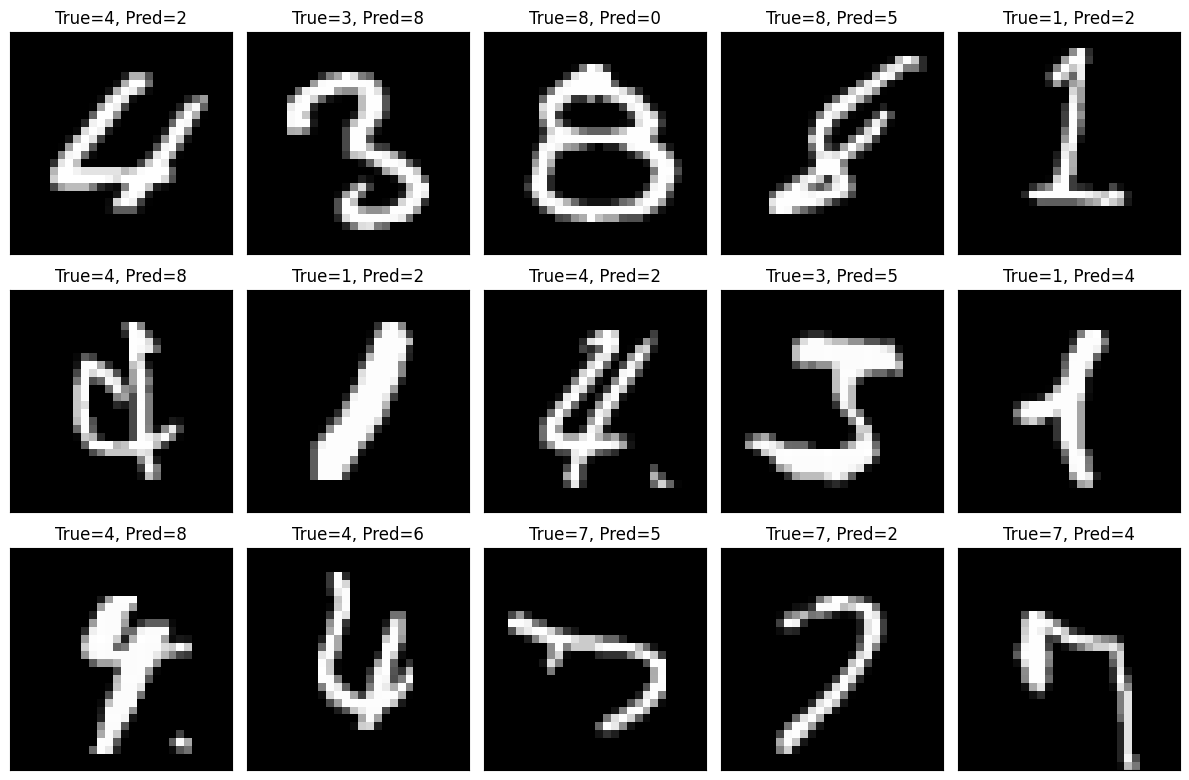

In [13]:
import matplotlib.pyplot as plt
import itertools

fig, axes2D = plt.subplots(3, 5, figsize=(12, 8))
axes = list(itertools.chain.from_iterable(axes2D))  # Flatten 2D list
X_test_miss, _ = ds_test[loc]
Y_test_miss = Y_true_labels[loc]
Y_pred_miss = Y_pred_labels[loc]
for idx, ax in enumerate(axes):
    if idx < loc.sum():
        ax.imshow(X_test_miss[idx].view(28, 28), cmap="gray")
        ax.set_title(f"True={Y_test_miss[idx]}, Pred={Y_pred_miss[idx]}")
    else:
        ax.axis("off")  # Hide unused axes
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()